In [1]:
import numpy as np
import pylab as plt  
import scipy.stats as stats
import scipy
from tqdm import tqdm

from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from sklearn.neighbors import KernelDensity

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
random_state = np.random.RandomState(seed=22)

### Define function f

$$f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}} = \frac{M_{\rm irr}}{M}$$


In [3]:
def f_ (chi):
    return np.sqrt( (1 + np.sqrt(1-chi**2)) / 2)

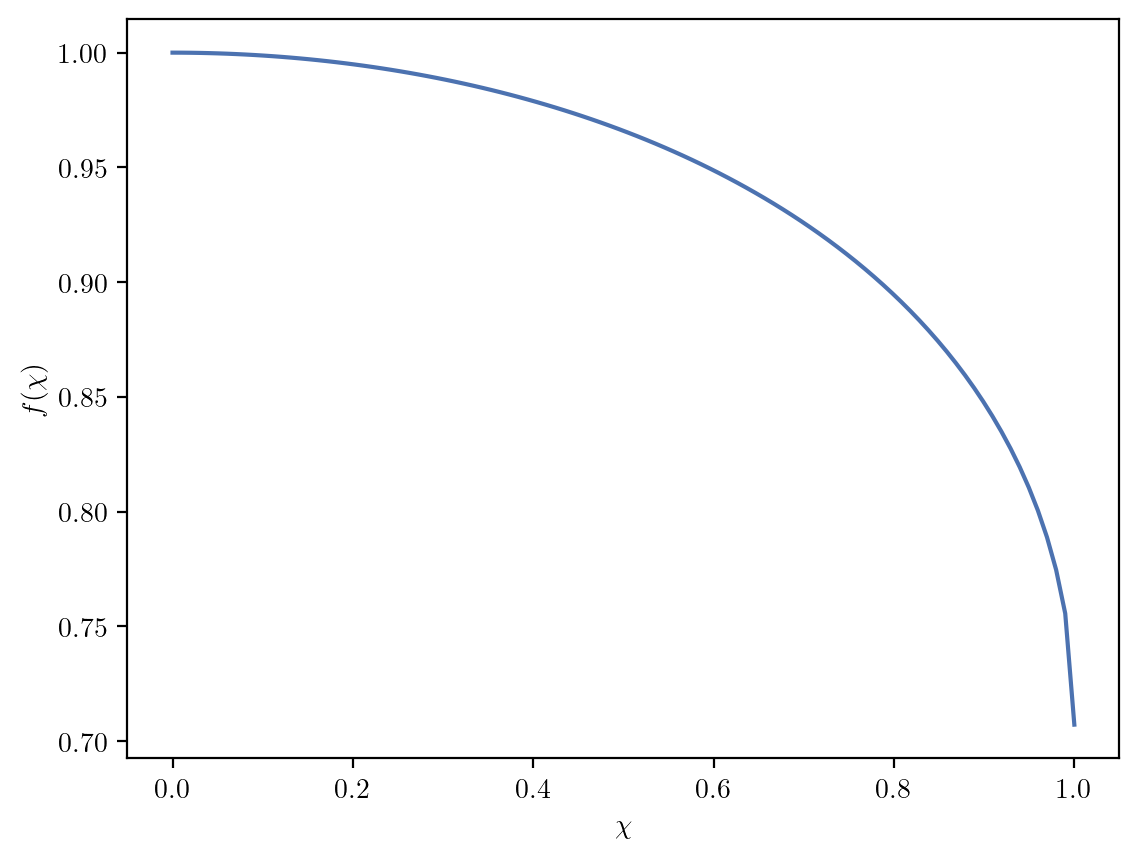

In [4]:
x_grid_ = np.linspace(0,1,100)
plt.plot(x_grid_,f_(x_grid_));
plt.xlabel(r'$\chi$')
plt.ylabel(r'$f(\chi)$');

### Irreducible mass (normally distributed) and simple histograms with arbitrary number of bins

In [5]:
mean = 1
sigma = 0.02  # scale, not a parameter --> all masses of the problem are in units of mu
N = 10000

gauss_M = norm(loc=mean, scale=sigma) # distribution for M
uniform_chi = uniform(0,1) # distribution for chi

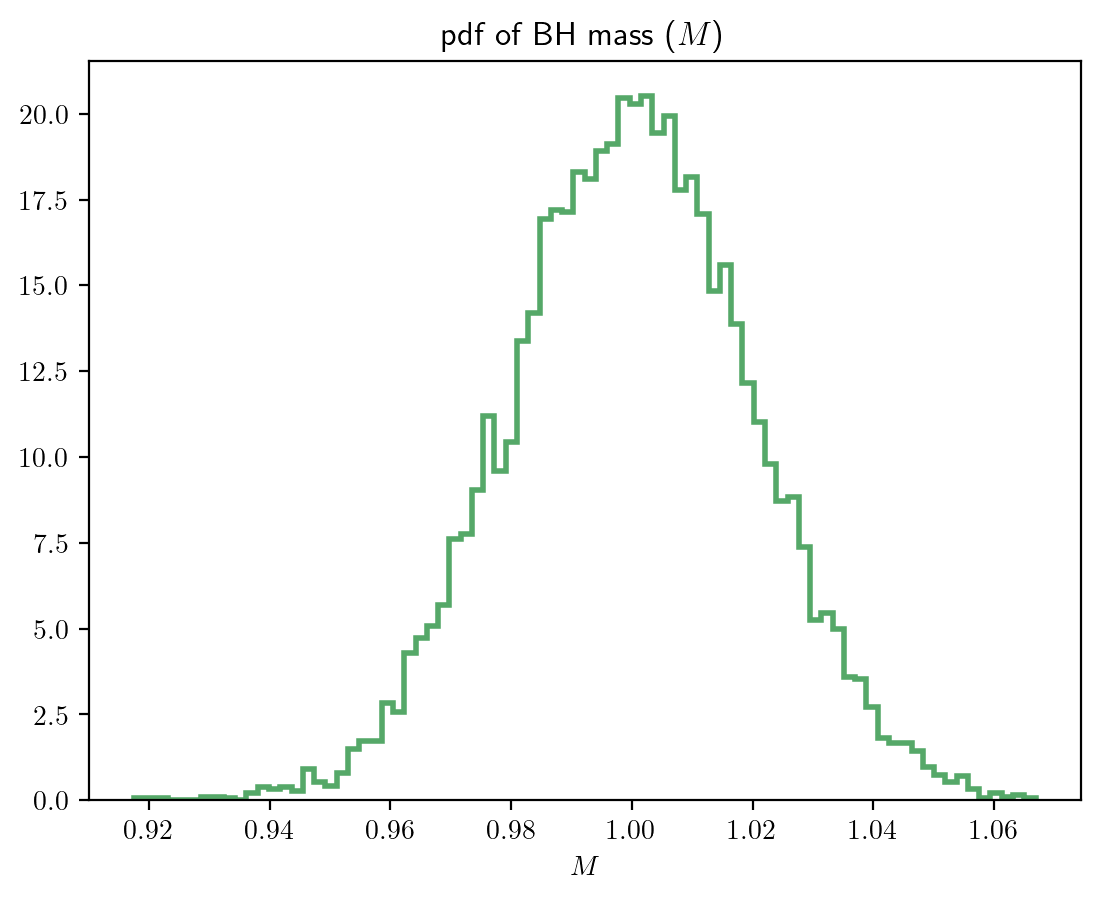

In [6]:
M = gauss_M.rvs(size=N)
chi = uniform_chi.rvs(size=N)

plt.hist(M,density=True,histtype='step',bins=80,lw=2,color='C1')
plt.xlabel('$M$')
plt.title('pdf of BH mass ($M$)')
plt.show()

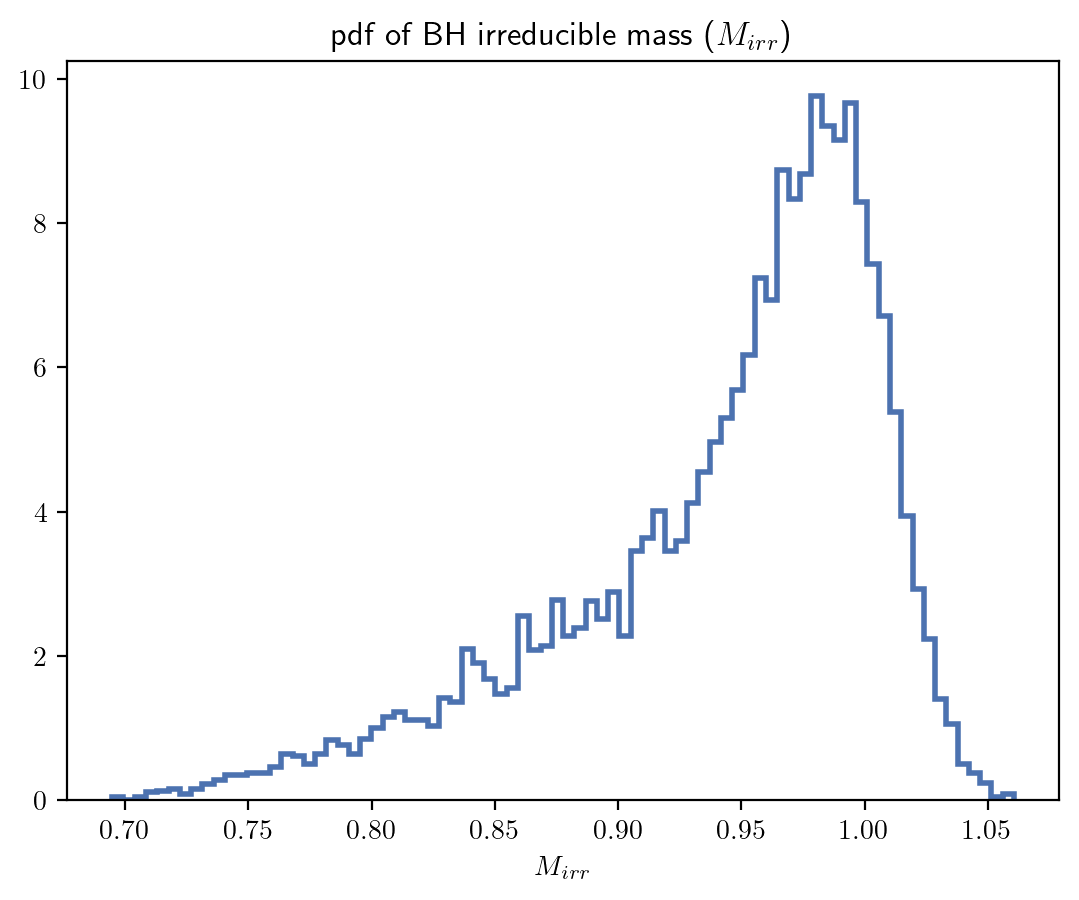

In [7]:
M_irr = f_(chi) * M


plt.hist(M_irr, density=True, bins=80, histtype='step', lw=2)
plt.xlabel(r'$M_{irr}$')
plt.title('pdf of BH irreducible mass ($M_{irr}$)')
plt.show()

### Histogram using the **"Freedman-Diaconis rule"**

Number of bins:51


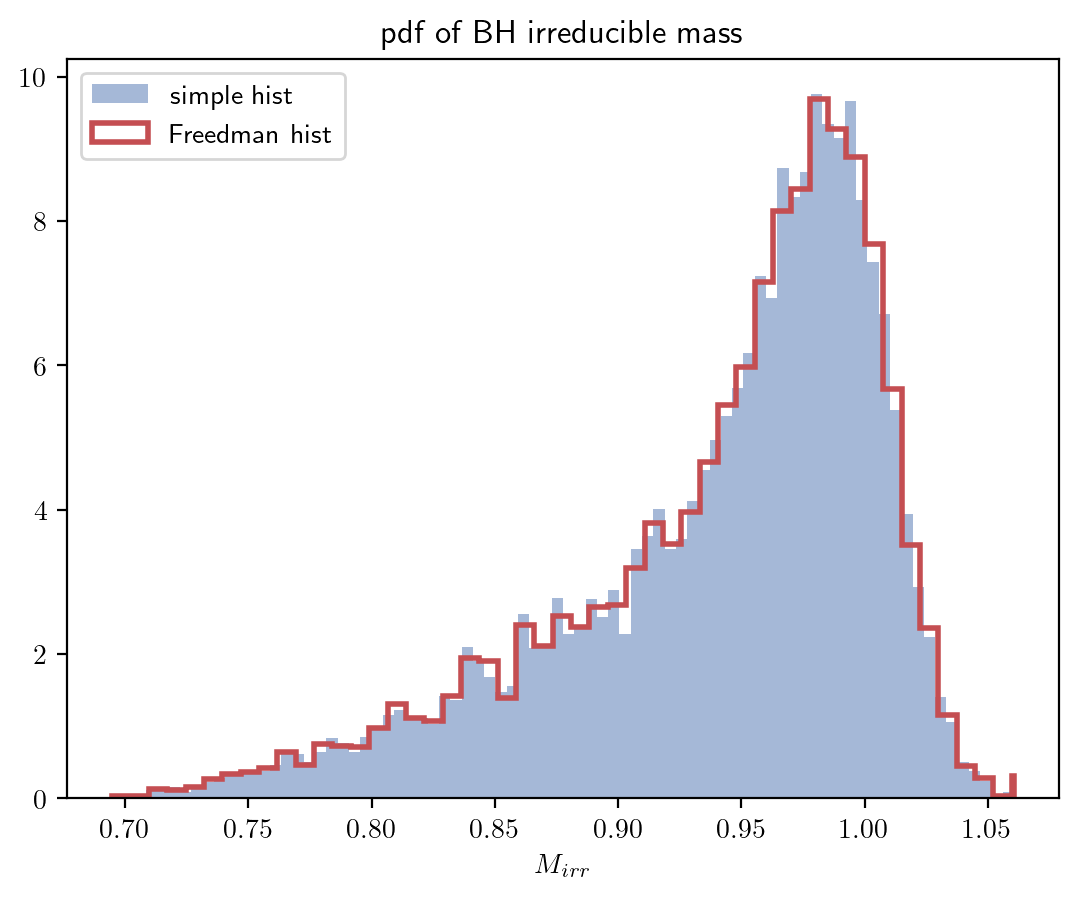

In [8]:
sigmaG2 = astroMLstats.sigmaG(M_irr)

binsize = 2.7*sigmaG2/(N**(1/3)) # Freedman-Diaconis

binsG = np.append(np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsize) , M_irr.max())
print("Number of bins:" + str(len(binsG)))

plt.hist(M_irr, density=True, bins=80, alpha=0.5, label='simple hist')
plt.hist(M_irr, bins=binsG, density=True, lw=2, histtype='step', color='C2', label='Freedman hist')

# Quicker:
# _ = hist(x, bins="freedman", histtype="step",density=True)

plt.xlabel(r'$M_{irr}$')
plt.title('pdf of BH irreducible mass')
plt.legend()
plt.show()

### Plot M_irr with a KDE

In [9]:
def kde_sklearn(data, bandwidth, kernel):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis])
    return np.exp(log_pdf)

100%|█████████████████████████████████████████████| 3/3 [00:08<00:00,  2.75s/it]


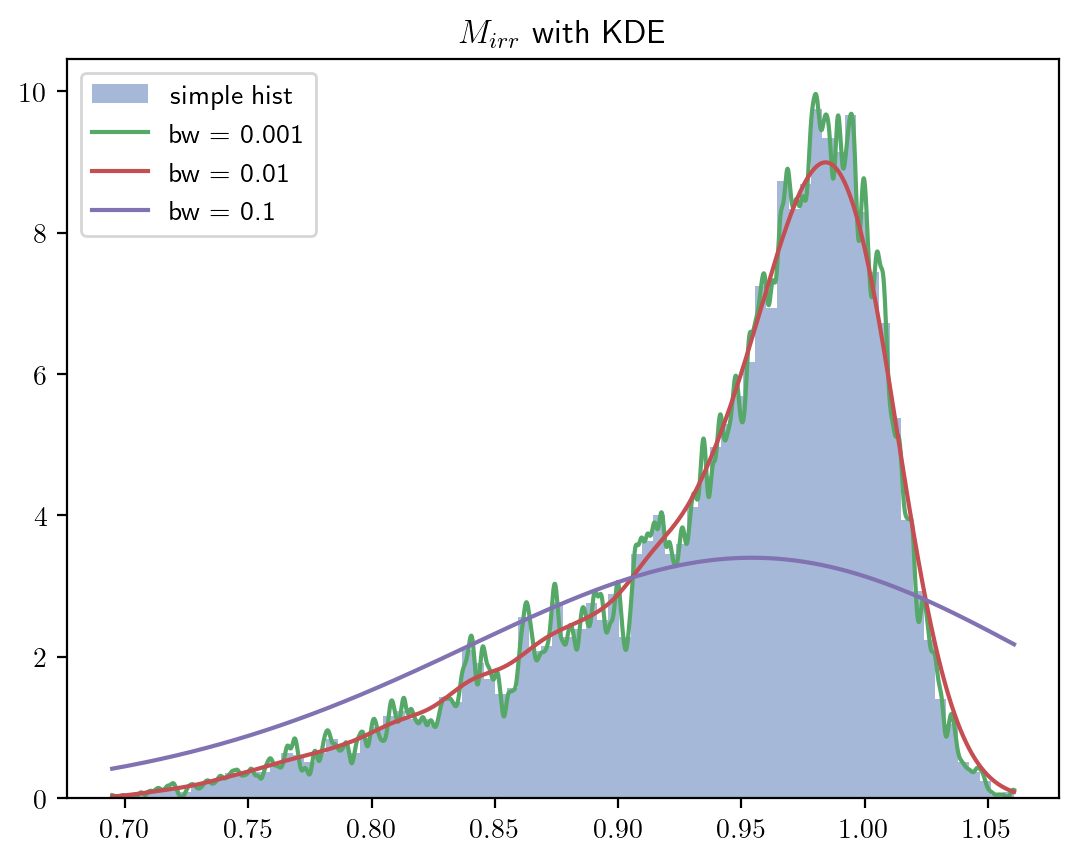

In [10]:
xgrid = np.linspace(M_irr.min(),M_irr.max(),N) 

plt.hist(M_irr, density=True, bins=80, alpha=0.5, label='simple hist')

bandwidth = [0.001, 0.01, 0.1]
for bw in tqdm(bandwidth):
    PDF_M_irr = kde_sklearn(M_irr,bandwidth=bw,kernel="gaussian")
    plt.plot(xgrid, PDF_M_irr, lw=1.5,  label='bw = '+str(bw))
    
plt.title(r'$M_{irr}$ with KDE')
plt.legend()
plt.show()

### KS distances of M_irr from M and f

In [11]:
sigmas = np.logspace(-5,3,20)
ksM = []
ksf = []

f_chi = f_(chi)

for sigma in sigmas:
    M=norm(loc=mean,scale=sigma).rvs(size=N)
    ksM.append(scipy.stats.ks_2samp(M, M*f_chi))
    ksf.append(scipy.stats.ks_2samp(f_chi, M*f_chi))

ksM= np.array(ksM)
ksf= np.array(ksf)

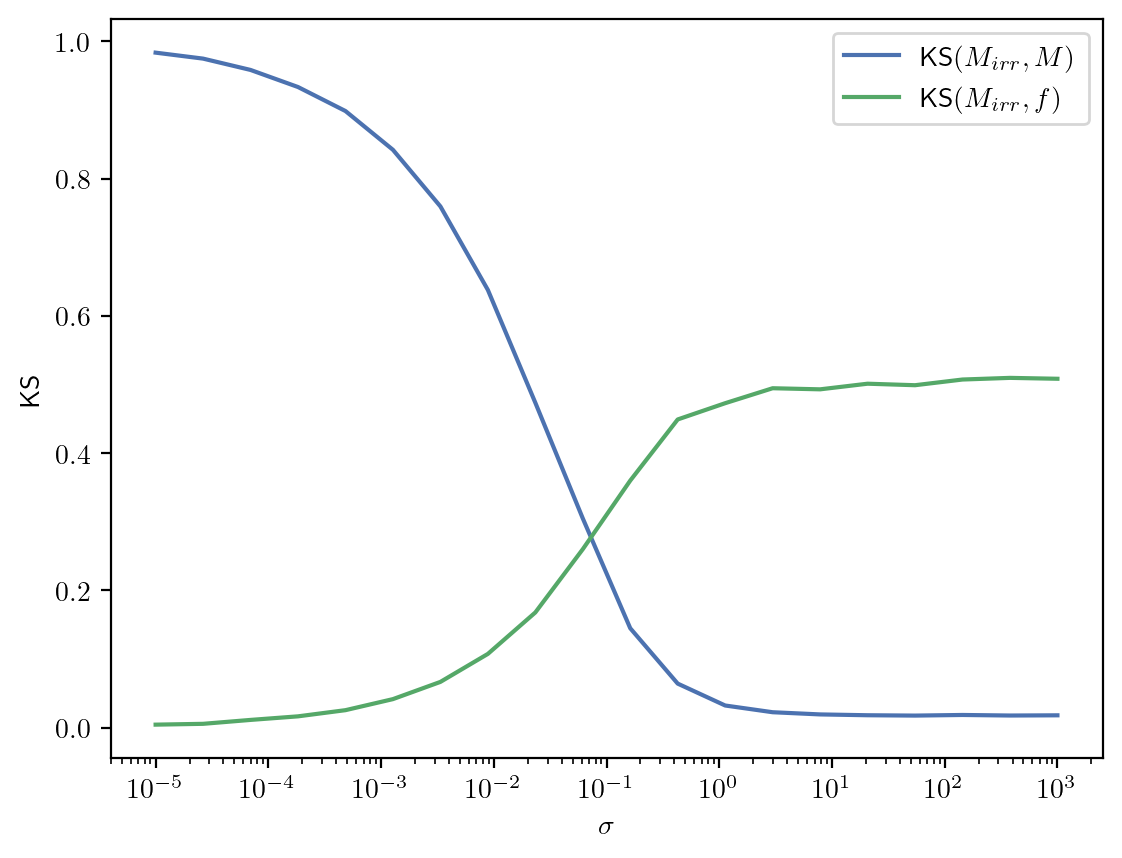

In [12]:
plt.plot(sigmas,ksM[:,0],label="KS$(M_{irr}, M)$")
plt.plot(sigmas,ksf[:,0],label="KS$(M_{irr}, f)$")
plt.semilogx()
plt.xlabel(r"$\sigma$")
plt.ylabel('KS')
plt.legend();

- M_irr distributed like f for $\sigma \ll  \mu$
- M_irr distributed like M for $\sigma \gg  \mu$

### Compute the pdf of $M_{\rm irr}$ from its mathematical definitions and compare it with previous results

## Analytic pdf of $M_{irr}$

Consider the pdf of $f$:

\begin{equation}
f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\end{equation}

To perform the change of variable:

- find the inverse function $\chi(f)$
    \begin{equation}
        \chi = 2f\sqrt{1-f^2}
    \end{equation}

- calculate $\frac{d\chi}{df}$
    \begin{equation}
        \frac{d\chi}{df} = \frac{2-4f^2}{\sqrt{1-f^2}}
    \end{equation}


- get $\pi(f)$ as $\pi(f)$ = $\pi(\chi)* | \frac{d\chi}{df} |$. Since chi is uniformly distributed between 0 and 1, so $\pi_{\chi}(\chi) $ =  1 for chi in [0,1],
    \begin{equation}
        \pi(f) = 2\frac{2f^2-1}{\sqrt{1-f^2}}
    \end{equation}



To get $ M_{irr}$ we can use the theorem of the distribution of the product of two random variables ([here](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables)). So eventually we need to solve numerically:

\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. 
\end{equation}


In [13]:
mean = 1
sigma = 0.02  
#N = 1000

#M = gauss_M.rvs(size=N)
#chi = uniform_chi.rvs(size=N)
#M_irr = f_(chi) * M

x = np.linspace(M_irr.min(),M_irr.max(),N) 

def integrand(f,x):
    return (np.sqrt(2/np.pi) / sigma ) * np.exp(-(x/f -1)**2 /(2*sigma**2)) * (2*f**2-1)/np.sqrt(1 - f**2) / f

Mirr_pdf = [scipy.integrate.quad(lambda f: integrand(f,xt), 1/(2**0.5),1)[0] for xt in x]

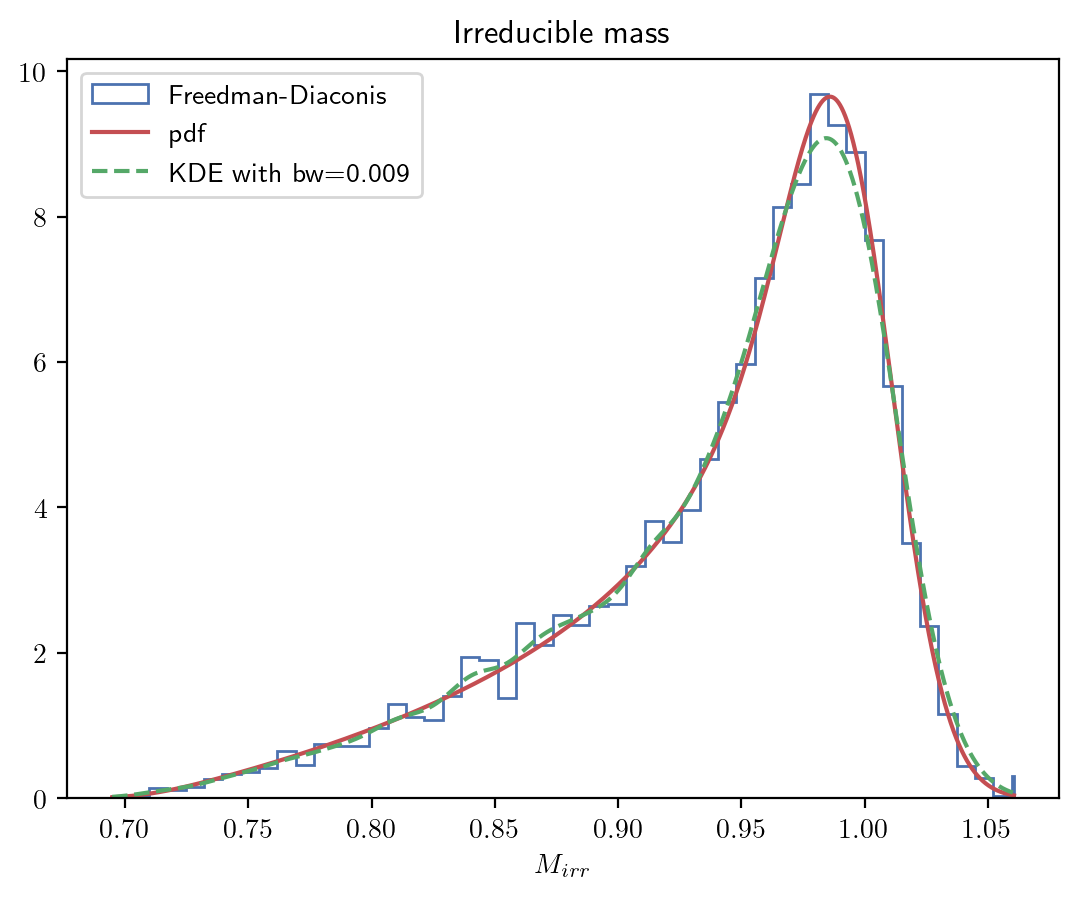

In [14]:
plt.hist(M_irr, bins=binsG, density=True, histtype = 'step', label='Freedman-Diaconis')

plt.plot(x, Mirr_pdf, label='pdf', c='C2')

kde_M_irr = kde_sklearn(M_irr,bandwidth=0.009,kernel="gaussian")
plt.plot(xgrid, kde_M_irr, label='KDE with bw='+str(0.009), ls='--',color='C1')

plt.xlabel(r'$M_{irr}$')
plt.title('Irreducible mass')
plt.legend()
plt.show()